In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit by dilfactor'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

def k1mod(params,ligs,noise=None):
    '''
    theoretical model for single binding site
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    sat = (k1*ligs)/(1 + k1*ligs)

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod(params,ligs,noise=None):
    '''
    theoretical model for a two-site receptor
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[1]
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod_fix(params,ligs,noise=None):
    '''
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[0]/4
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def obj(guess,model,data):
    return model(guess,data[0])[1] - data[1]

def obj_wt(guess,model,data,wt):
    return (model(guess,data[0])[1] - data[1])/(wt*data[1])

def fit(data,model,guess):
        return sp.optimize.least_squares(obj,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def fit_wt(data,model,guess,wt):
        return sp.optimize.least_squares(obj_wt,guess,args=(model,data,wt),ftol=1e-14,gtol=1e-14,xtol=1e-14)

def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [3]:
def lhood(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/((f*data[1])**2)
    return -0.5*(np.sum((data[1] - model(params,data[0])[1])**2*invsig2 - np.log(invsig2)))

def lnpri(guess,bounds):
    assert len(bounds) == len(guess)
    if all([bounds[i][0] <= guess[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf
    
def lnprob(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood(guess,model,data)

def lhood2(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/(data[1]**2 * np.exp(2*f))
    return -0.5*(np.sum(((model(params,data[0])[1] - data[1])**2 * invsig2 - np.log(invsig2))))

def lnprob2(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood2(guess,model,data)

def lnpri_EXP(guess):
    k1 = guess[0]
    k2 = guess[1]
    f = guess[2]
    
    if 0.01 < k1 < 10. and 0.01 < k2 < 10. and 0.001 < f < 0.5:
        return 0.0
    else:
        return -np.inf
    
def lnprob_EXP(guess,model,data):
    lp = lnpri_EXP(guess)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood(guess,model,data)

In [4]:
ligs = dilser()

In [5]:
k1parms = np.array([1.])
k1datset = [k1mod(k1parms,ligs,noise=0.05) for i in range(100)]

In [6]:
nll = lambda *args: -lhood(*args)

In [8]:
guess_fork2fit = np.array([2.,0.5,0.05])
bnds_fork2fit = ((0.01,10.),(0.01,10.),(0.001,0.1))

In [9]:
res = np.array([sp.optimize.minimize(nll,guess_fork2fit,args=(k2mod,i),method='L-BFGS-B',bounds=bnds_fork2fit,options={'ftol':1e-14,'gtol':1e-14}).x for i in k1datset]) 

(array([  1.,  11.,  18.,  20.,  23.,  14.,   7.,   2.,   3.,   1.]),
 array([ 0.02631821,  0.03105592,  0.03579363,  0.04053134,  0.04526905,
         0.05000677,  0.05474448,  0.05948219,  0.0642199 ,  0.06895761,
         0.07369532]),
 <a list of 10 Patch objects>)

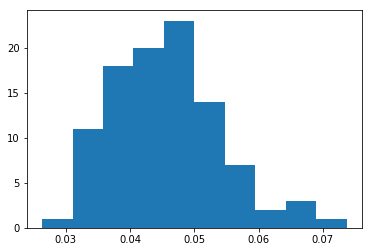

In [10]:
plt.hist(res[:,2])

In [28]:
ndim, nwalkers = 3, 50

In [29]:
pos = [guess_fork2fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_EXP, args=(k2mod,k1datset[0]))

In [31]:
sampler.run_mcmc(pos, 500);

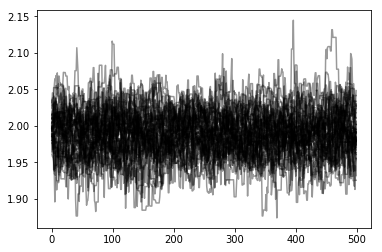

In [32]:
plt.plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4);

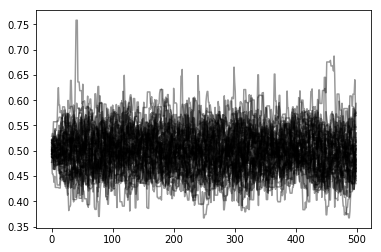

In [33]:
plt.plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4);

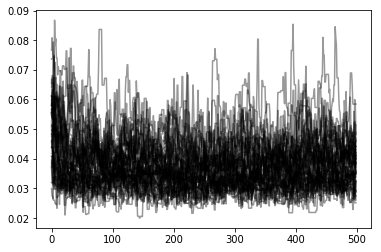

In [34]:
plt.plot(sampler.chain[:, :, 2].T, color="k", alpha=0.4);

In [44]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

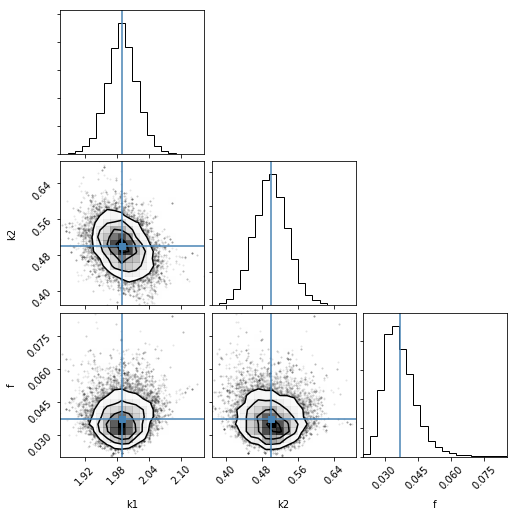

In [46]:
fig=corner.corner(samples, labels=['k1','k2','f'],truths=np.mean(samples,axis=0))

In [50]:
np.mean(samples,axis=0)

array([ 1.98931506,  0.49914538,  0.03707688])

{'boxes': [<matplotlib.lines.Line2D at 0x11ef84d30>],
 'caps': [<matplotlib.lines.Line2D at 0x11ef8ada0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11ef92ba8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11ef8e940>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11ef84fd0>,
  <matplotlib.lines.Line2D at 0x11ef87b38>]}

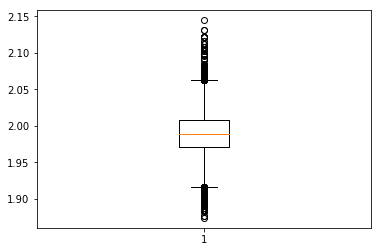

In [51]:
plt.boxplot(samples[:,0])

In [57]:
[(np.percentile(samples[:,i],16), np.percentile(samples[:,i],50), np.percentile(samples[:,i],84)) for i in range(3)]

[(1.9620698441094613, 1.9894031623127322, 2.0167997799264188),
 (0.46137326618978663, 0.49842226376097448, 0.53586555216094989),
 (0.030303815582573113, 0.035926149950867521, 0.043825972843702432)]

In [62]:
np.percentile((samples[:,0] / samples[:,1]),16),np.percentile((samples[:,0] / samples[:,1]),50),np.percentile((samples[:,0] / samples[:,1]),84)

(3.6883490871434281, 3.988884011785526, 4.3370453948686398)

In [64]:
samplers = [emcee.EnsembleSampler(nwalkers, ndim, lnprob_EXP, args=(k2mod,i)) for i in k1datset]

In [65]:
runs = [i.run_mcmc(pos, 500) for i in samplers]

In [67]:
samplesSET = [i.chain[:, 50:, :].reshape((-1, ndim)) for i in samplers]

(array([  2.,   8.,   7.,  18.,  17.,  14.,  11.,   8.,   7.,   8.]),
 array([ 2.94329597,  3.1387991 ,  3.33430223,  3.52980537,  3.7253085 ,
         3.92081163,  4.11631476,  4.3118179 ,  4.50732103,  4.70282416,
         4.89832729]),
 <a list of 10 Patch objects>)

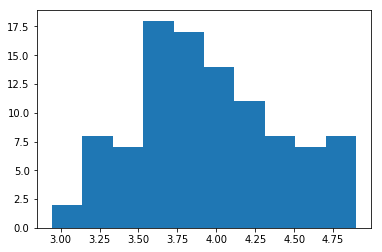

In [76]:
plt.hist([np.percentile(i[:,0]/i[:,1],50) for i in samplesSET])